# Chart: Portfolio Composition Map of the Efficient Frontier


0.005364443384876672 0.057662625455281113


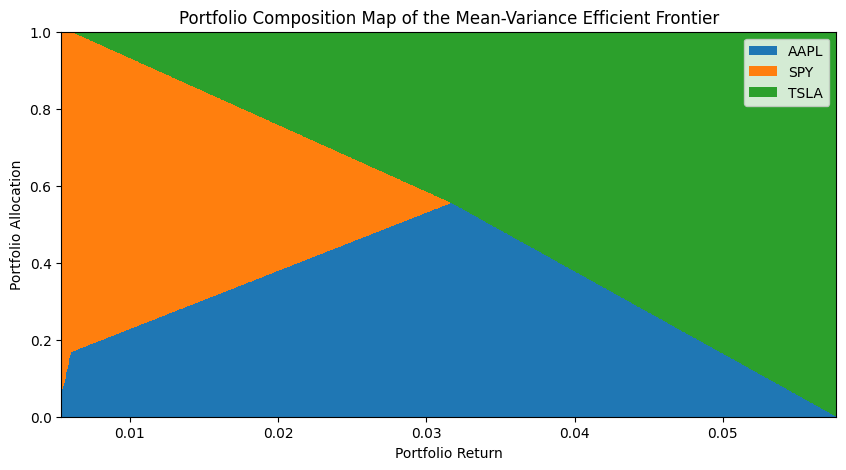

In [ ]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

historical_prices_url = "https://raw.githubusercontent.com/bu-cds-omds/dx704-examples/refs/heads/main/data/prices-monthly.tsv"
historical_prices = pd.read_csv(historical_prices_url, sep="\t")
historical_prices = historical_prices.set_index("date")

historical_returns = historical_prices.pct_change().dropna()
estimated_returns = historical_returns.mean().rename("return")
estimated_variances = historical_returns.var()

estimated_covariance = historical_returns.cov()

# minimum risk portfolio

n = len(estimated_returns)

x_minimum_risk = cp.Variable(n)

objective_minimum_risk = cp.Minimize(x_minimum_risk.T @ estimated_covariance.to_numpy() @ x_minimum_risk)
objective_minimum_risk

prob_minimum_risk = cp.Problem(objective_minimum_risk,
                               [0 <= x_minimum_risk,
                                cp.sum(x_minimum_risk) == 1])

covariance_minimum_risk = prob_minimum_risk.solve()
covariance_minimum_risk

estimated_return_minimum_risk = x_minimum_risk.value.T @ estimated_returns
estimated_return_minimum_risk

# efficient frontier

ef_variances = []
ef_returns = []
ef_portfolios = []

for r in np.linspace(estimated_return_minimum_risk, max(estimated_returns), 1001):
    # create variables to optimize
    x_r = cp.Variable(n)

    # formulate linear program
    prob_r = cp.Problem(cp.Minimize(x_r.T @ estimated_covariance.to_numpy() @ x_r),
                        [0 <= x_r,
                         cp.sum(x_r) == 1,
                         x_r.T @ estimated_returns == r])
    ef_variances.append(prob_r.solve())
    ef_returns.append(r)
    ef_portfolios.append(x_r.value)

ef_portfolios = np.asarray(ef_portfolios)

plt.figure(figsize=(10, 5))

bottom = np.zeros(ef_portfolios.shape[0])
for (i, a) in enumerate(historical_returns.columns):
    plt.bar(x=ef_returns,
            height=ef_portfolios[:,i],
            bottom=bottom,
            label=a,
            width=(ef_returns[1] - ef_returns[0]))
    bottom += ef_portfolios[:,i]

plt.legend()
plt.xlabel("Portfolio Return")
plt.xlim(min(ef_returns), max(ef_returns))
plt.ylabel("Portfolio Allocation")
plt.ylim(0, 1)
plt.title("Portfolio Composition Map of the Mean-Variance Efficient Frontier")

plt.show();